## Joining Methods (20 points)

In [89]:
#import packages here
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

#### In this notebook, several aspects of joining methods will be considered.

### Question 1.1 (3 points)

#### Two carbon fibre parts are to be adhesively bonded, as in the figure below. The following information is provided: Adherends Youngs modulus = 70 GPa, adherends thickness = 2 mm, adherends width = 20 mm, adhesive shear modulus = 2.0 GPa, adhesive thickness = 0.3 mm, overlap length = 30 mm. The bonded part will be subjected to a tensile load of 50 kN.

#### - In the lectures you learned about the shear-stress distribution of such a joint. Plot the shear stress distribution over the lap joint for several overlap lengths (including at least: 10, 15, 20, 30, and 50 mm) according to the Klein model. Comment on the results.

#### - Then, repeat the exercise using the Volkersen model instead. What are the most notable differences?

![title](lapjoint.png)

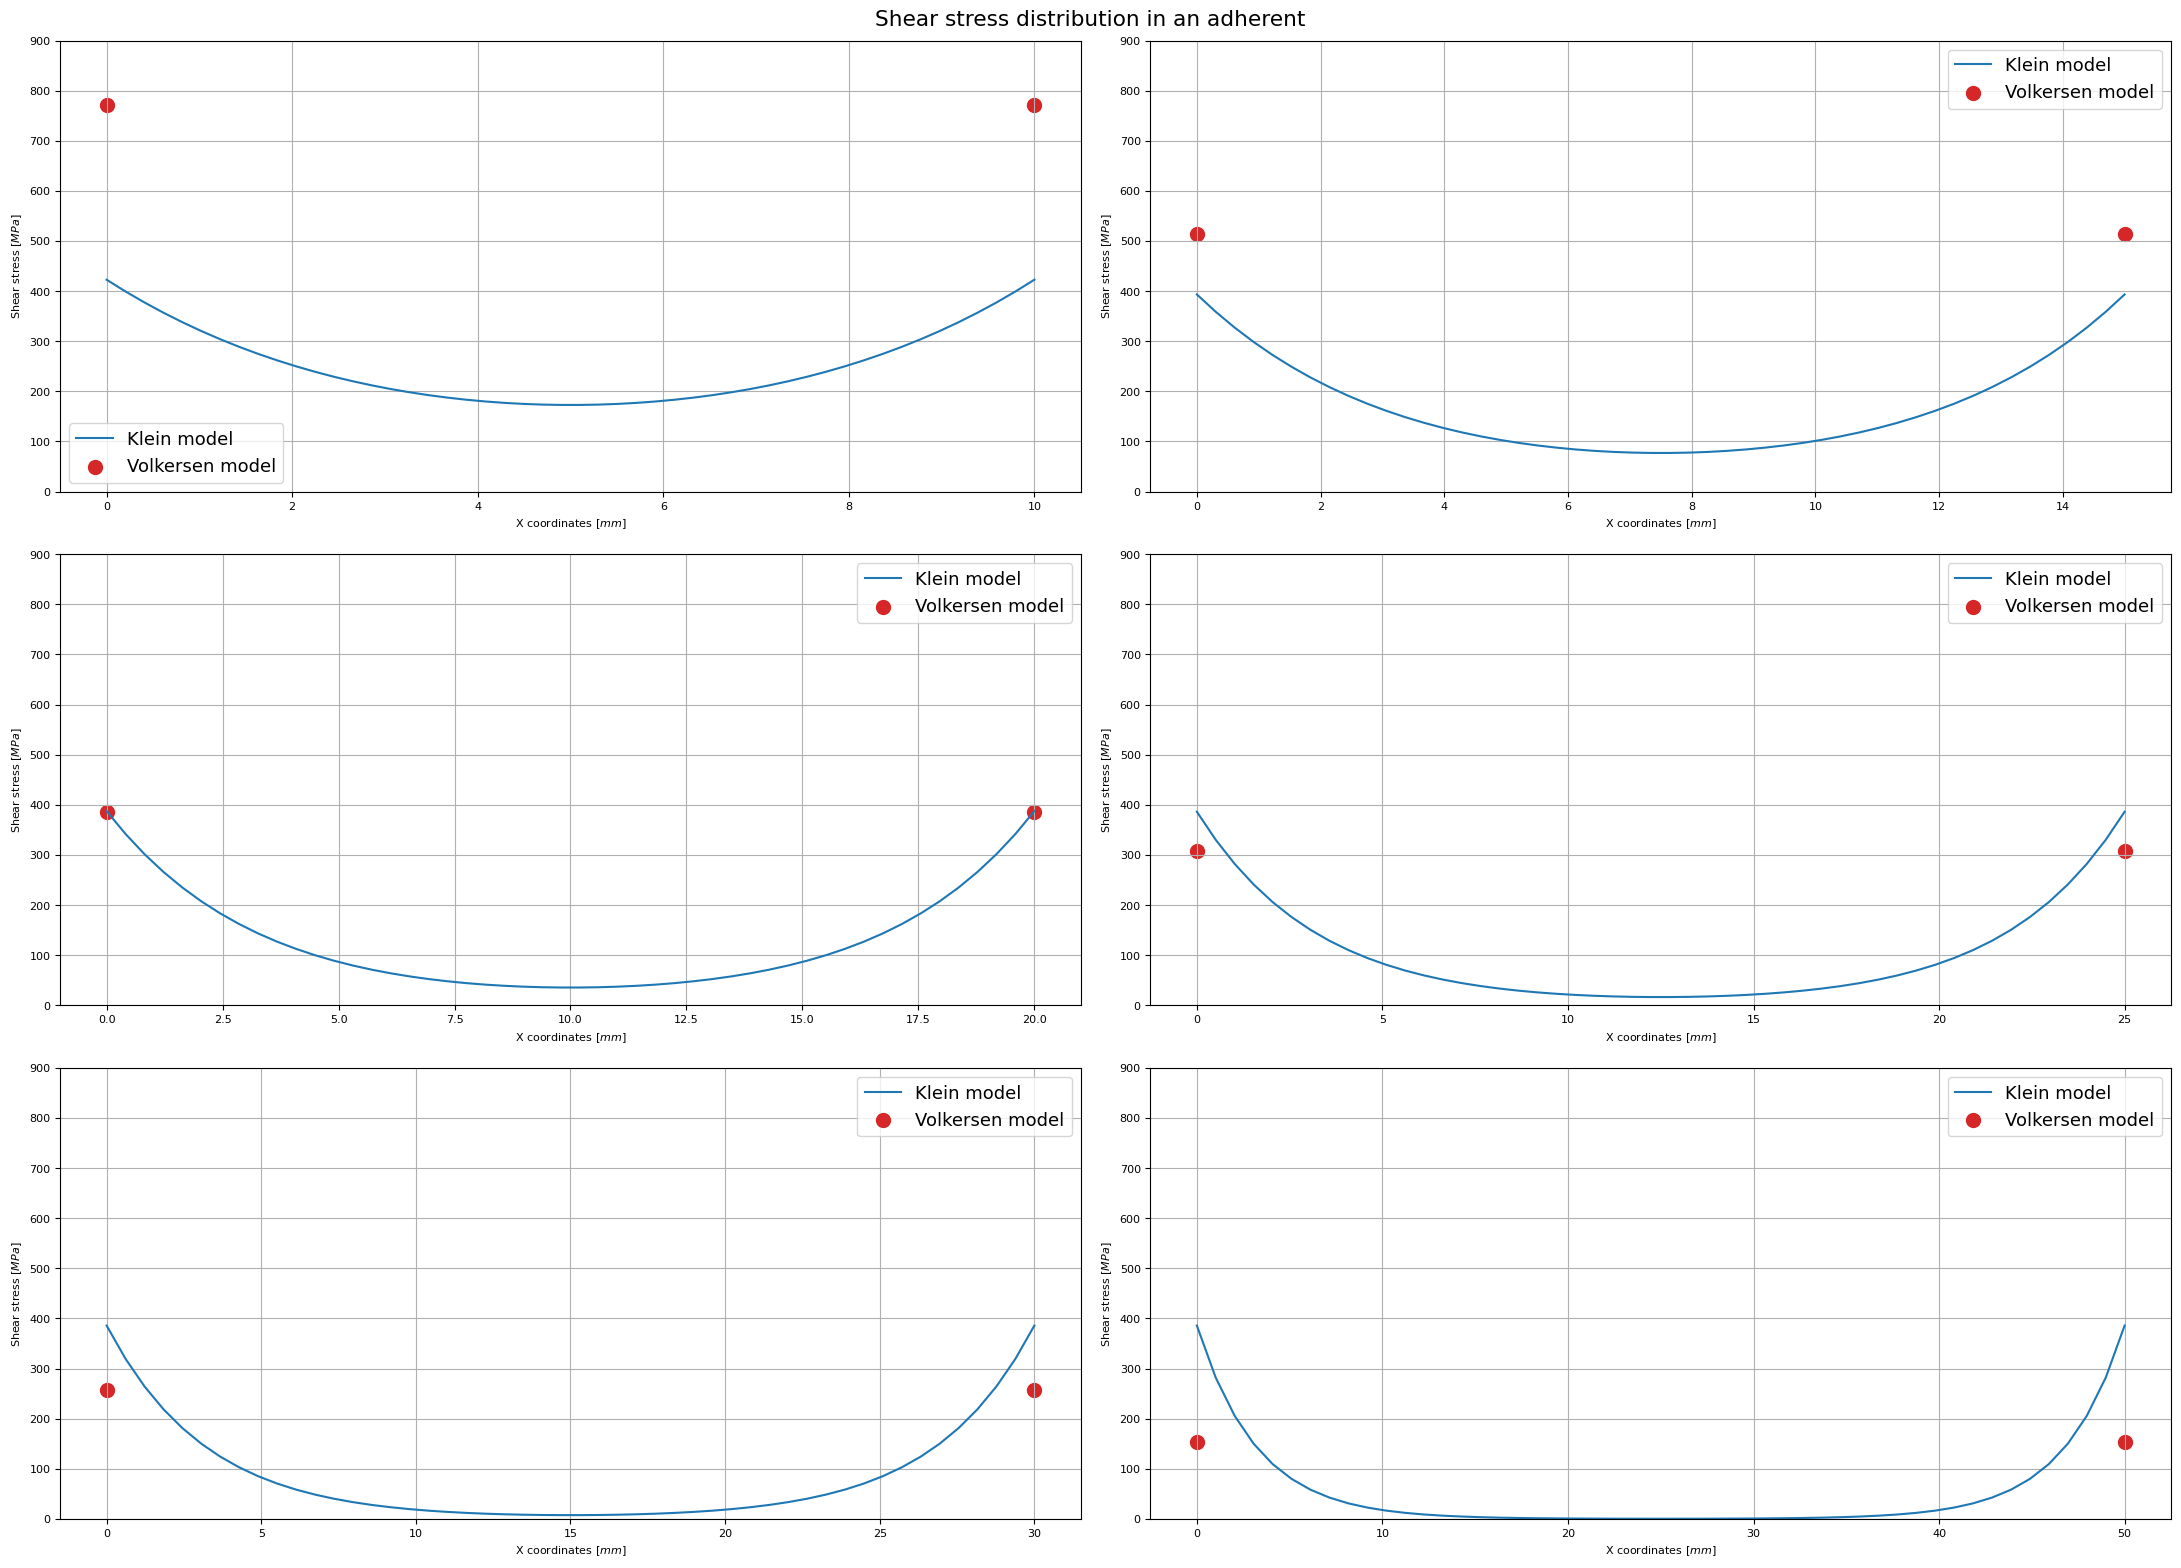

In [90]:
# Storing material properties in a convenient way
class Material:
    def __init__(self, G_kl=1, E1=1, t1=1, E2=1, t2=1, lu=1, d=1, b=1):
        self.G_kl = G_kl # shear modulus of the adhesive
        self.E1 = E1 # stiffness of the bottom sheet
        self.t1 = t1 # thickness of the bottom sheet
        self.E2 = E2 # stiffness of the top sheet
        self.t2 = t2 # thickness of the top sheet
        self.lu = lu # length of the joint
        self.d = d # thickness if the adhesive
        self.b = b # width of the panel


def klein_model(N, Mat, F_applied):
    G_kl, E1, t1, E2, t2, lu, d, b = (Mat.G_kl, Mat.E1, Mat.t1, Mat.E2, Mat.t2, Mat.lu, Mat.d, Mat.b)
    x_array = np.linspace(0, lu, N)

    tau_mean = F_applied / b / lu
    beta = ((E2 * t2 - E1 * t1) * G_kl * lu ** 2) / (E1 * t1 * (G_kl * lu**2 + E2 * t2 * d))
    omega = np.sqrt((G_kl * (E1 * t1 + E2 * t2) * lu ** 2) / (E1 * t1 * E2 * t2 * d))

    # Coeffs k used to split up the equation and make it more readable
    k1 = omega * tau_mean / (beta + 2) / (np.cosh(omega) - 1)
    k2 = np.sinh(omega * (1 - x_array / lu))
    k3 = (beta + 1) * np.sinh(omega * x_array / lu)
    return x_array, k1 * (k2 + k3)


# https://www.sciencedirect.com/science/article/pii/S0143749612000103?casa_token=D7Ai3sGpUxQAAAAA:1-4qyEJVk9hVCwdG-v1fFVVwKeAgBbTQDcr0diMWQtP0TwG5Nq0KmNGA6aciT2WjdFyvUONqSzI
def volkersen_model(Mat, F_applied):
    G_kl, E1, t1, E2, t2, lu, d, b = (Mat.G_kl, Mat.E1, Mat.t1, Mat.E2, Mat.t2, Mat.lu, Mat.d, Mat.b)
    E = E1
    t = t1

    tau_max = F_applied / lu * np.sqrt(G_kl / 2 / E / t / d)

    # omega = np.sqrt(G_kl / E / t1 / d * (1 + t1 / t2))
    #
    # taux = F_applied * omega / 2 / b * (np.cosh(omega * x_array)) / np.sinh(omega * lu / 2) + (t1 - t2) / (t1 + t2) * omega * lu / 2 * np.sinh(omega * x_array) / np.cosh(omega * lu / 2)
    return tau_max


F = 50e3
N = 50
lengths = np.array([10, 15, 20, 25, 30, 50]) * 1e-3

w = 3
h = 2
fig, axs = plt.subplots(w, h, figsize=(22, 16))
matplotlib.rc('font', **{'size': 13})
fig.suptitle("Shear stress distribution in an adherent")


for idx, length in enumerate(lengths):
    Mat1 = Material(t1=2e-3, t2=2e-3, b=20e-3, E1=70e9, E2=70e9, G_kl=2e9, d=0.3e-3, lu=length)

    xs, taux_klein = klein_model(N, Mat1, F)
    tau_max_volk = volkersen_model(Mat1, F)

    idx1 = idx % h
    idx2 = int(idx / h)


    axs[idx2][idx1].plot(xs * 1e3, taux_klein / 1e6, label="Klein model")
    axs[idx2][idx1].scatter(xs[[0, -1]] * 1e3, [tau_max_volk / 1e6, tau_max_volk / 1e6], label="Volkersen model", color='tab:red', s=100)
    axs[idx2][idx1].set_xlabel(r"X coordinates $[mm]$")
    axs[idx2][idx1].set_ylabel(r"Shear stress $[MPa]$")
    axs[idx2][idx1].legend()
    axs[idx2][idx1].grid()
    axs[idx2][idx1].set_ylim(0, 900)

fig.tight_layout()
plt.show()


In the image above the results for Klein and Volkersen model are given for various lengths of the joint. The Klein model yields the typical bathtub curve while the Volkersen model determines only the maxima at the edges. To calculate the shear distribution according to the Klein model, the equation below was used:
\begin{equation}
\tau(\mathrm{x})=\frac{\omega \cdot \tau_{\mathrm{m}}}{(\beta+2) \cdot(\cosh \omega-1)}\left[\sinh \left(\omega\left(1-\frac{\mathrm{x}}{l_{u}}\right)\right)+(\beta+1) \sinh \left(\omega \frac{\mathrm{x}}{l_{u}}\right)\right]
\end{equation}
where
\begin{equation}
\omega=\lambda \cdot l_u=\sqrt{\frac{G_{K 1}\left(E_1 \cdot t_1+E_2 \cdot t_2\right) l_{u}^2}{E_1 \cdot t_1 \cdot E_2 \cdot t_2 \cdot d}}
\end{equation}
\begin{equation}
\tau_m = \frac{F}{l_u b}
\end{equation}
and
\begin{equation}
\beta=\frac{\left(E_2 \cdot t_2-E_1 \cdot t_1\right) G_{K 1} \cdot l_u^2}{E_1 \cdot t_1\left(G_{K 1} \cdot l_u{ }^2+E_2 \cdot t_2 \cdot d\right)}
\end{equation}
The variables are defined as G_kl ($G_{K1}$) for the shear modulus of the adhesive, E1 ($E_1$) for stiffness of the top bottom, t1 ($t_1$) for thickness of the bottom sheet, E2 ($E_2$) for stiffness of the top sheet, t2 ($t_2$) for thickness of the top sheet, lu ($l_u$) for length of the joint, d ($d$) for thickness if the adhesive, b ($b$) for the width of the panel. $\tau_m$ is the mean stress and is calculated by dividing the applied force by the lenght and width of the join.

The Volkersen approximation for maximum stress is given by:
\begin{equation}
\tau_{max} = \frac{F}{l_u} \sqrt{\frac{G_{Kl}}{2 E t t_k}}
\end{equation}
This model only gives the maximum stress at the joint ends and assumes that both adherents have the same stiffness.

The main difference between the two models is that the Volkersen model only gives the stress value at the edges of the joint. If this is used as an estimation for the stress in the entire adhesive, the average stress is highly overestimated. The Klein model predicts the typical "bathtub" shape of adhesive joints including the maxima at the edges. The Volkersen model predicts higher stress than the Klein model does for small joints and vice-versa for large joints.

Both models show stresses decreasing as the length of the joint is decreasing which is correct, although the reduction of stress is too rapid for the Volkersen model.

### Question 1.2 (2 points)

#### Show how the stress distribution changes when the thickness of the bottom adherend increases to 3mm and 4mm. Create a plot. Why can you expect these shapes of the curves? Answer in the textbox below your plot. Use the Klein model.

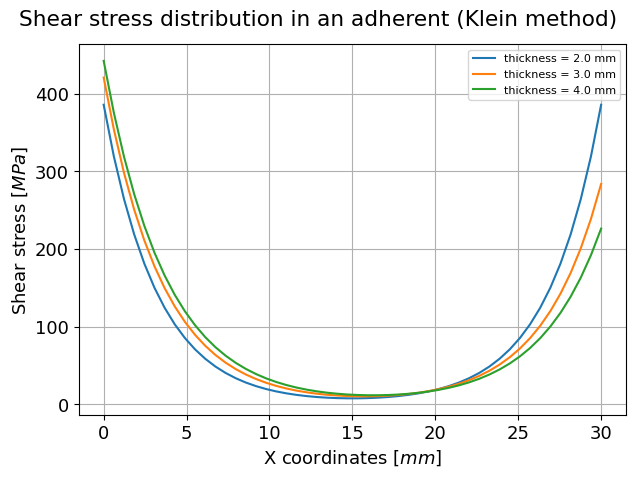

In [91]:
fig, axs = plt.subplots(1)
fig.suptitle("Shear stress distribution in an adherent (Klein method)")

thickness_list = np.array([2, 3, 4]) * 1e-3

for idx, t in enumerate(thickness_list):
    Mat1 = Material(t1=t, t2=2e-3, b=20e-3, E1=70e9, E2=70e9, G_kl=2e9, d=0.3e-3, lu=30e-3)

    xs, taux_klein = klein_model(N, Mat1, F)

    axs.plot(xs * 1e3, taux_klein / 1e6, label=f"thickness = {t * 1e3} mm")

matplotlib.rc('font', **{'size': 8})
axs.set_xlabel(r"X coordinates $[mm]$")
axs.set_ylabel(r"Shear stress $[MPa]$")
axs.legend()
axs.grid()

fig.tight_layout()
plt.show()



Answer:
In the figure above the stress distribution for a constant length joint is shown with various thicknesses of the bottom plate. It can be seen that as the asymmetry of the joint increases (the thicknesses of the plates becomes more different) the stress distribution becomes more asymmetric. This is because the thinner plate is less stiff and allows for more strain difference between the plates on the right side thus creating larger shear stress in the adhesive. On the left side of the joint the opposite effect takes place - top plate is highly stressed and more stiff but bottom plates is less stiff while experiencing low stress. Thus, the stress and stiffness differences between the two plates partially cancel out and reduce the shear stress in the adhesive. Both of reduced stress on the left side of the joint and increased stress on the right side of the joint can be seen in the figure generated using Klein model.

### Question 2 (2 points)

#### In reality, shear stresses are not the only stresses acting on the lap joint. Due to eccentricity, another type of stress occurs which will lower the maximum carrying capacity. Elaborate on this type of stress and why it effects the maximum load that can be carried.

Answer:
In addition to the shear stress, the edges of the join will experience peel stresses. A joint with an eccentricity (like a lap joint) experiences "secondary bending" under a tensile load. This bending is quantified by measuring the "out-of-plane displacements of the neutral line of the joint". This bending of the neutral axis induces stresses normal to the substrate surface that have a peel action. Similarly to the shear stress, the peel stresses are especially large at the edges of the joint. The maximum load that an adhesively bonded lap joint can have is therefore limited by the peel stress experienced which needs to be lower than the maximum allowable. Sometimes, peel stressed can be higher than the maximum allowable peel stress even when the shear stresses are below the maximum allowable shear stress.

(Schijve, Jaap. (2009). Fatigue of Structures and Materials. 10.1007/978-1-4020-6808-9., Mallick, P.K. (2007). Fiber-Reinforced Composites: Materials, Manufacturing, and Design, Third Edition (3rd ed.). CRC Press. https://doi.org/10.1201/9781420005981, Shigley JE, Mischke CR. Adhesive bonding and design considerations. In: Mechanical engineering design, 6th ed. McGraw-Hill; 2003. p. 562–78 (Chapters 9–11).)

### Question 3 (2 points)

#### Explain how step joints and scarf joints help in increasing the maximum carrying load, compared to lap joints. Do this by globally analyzing the differences between the 3 joint types, and how these differences result in different stresses.

Answer:
The fundamental difference between a lap joint and a scarf joint is the shear stress distribution (in the adhesive) over the length of the overlap. While the adhesive in a lap joint experiences a bathtub distribution, in an ideal scarf joint, the stress is constant along the entire length. Therefore, while the adhesive in a lap joint will have high peaks at the edges that rapidly lower into a relatively low value, the scarf joint will have the adhesive carrying the load homogeneously. This aspect of the scarf joint results in a lower maximum shear stress (for the same load and surface area). A lower maximum shear stress experienced results in a larger maximum carrying load, using the same material.

In both lap and scarf joints, the load is gradually transferred by the adhesive over the overlap length by an adherent to the other. The lack of the "bathtub" effect in a scarf joint is due to the fact that the cross-section of the adherents changes gradually over the overlap. The gradual change in thickness implies a change in stiffness of the adherent. This change is also matched by the gradual introduction of the load, such that the deformation of an adherent's section with a lower thickness and a lower experienced stress matches the deformation of the other adherent's section with a larger thickness and a larger load. A step joint has characteristics of both a step and a scarf joint as it is intrinsically a sequence of smaller steps arranged with the geometry of a scarf joint section (alternatively could be seen as a discretized scarf joint). Depending on the number of steps and the length of the overlap, the deformation of the adherents may match more closely that of a lap joint or a scarf joint. For each of the constant-thickness sections, the stresses peak at the edges. The larger peaks stay at the absolute edges of the overlap and are larger than those of a scarf joint since the change in thickness is not gradually matching the shear stress transfer but are smaller than the peaks of a lap joint as the difference in deformation of the adherents is smaller. Coinciding with the thickness drops, a rapid change in the shear stress is experienced as the surfaces are perpendicular to the load direction.

There is a further remarkable advantage that scarf and step joints have over lap joint (at the least in theory), it is the lack of secondary bending.This also contributes in raising the maximum carrying load.

The pictures illustrate the differences between the 3 different stress distributions, caused by the different geometries as explained above (SLJ = single lap joint). However, the data plot in the picture is obtained by FEM simulation and therefore shows peaks also for scarf joints even if the simplified theory treated earlier does not contemplate them.
(Picture from Barbosa, N.G.C., Campilho, R.D.S.G., Silva, F.J.G. et al. Comparison of different adhesively-bonded joint types for mechanical structures. Appl Adhes Sci 6, 15 (2018).)
![title](Joint_comparison.png)

### Question 4.1 (3 points)

#### The number of steps $n$ in a step joint has an effect on the shear-stress distribution in the bonded part. Write a function that takes the number of steps of the step joint as input, and returns the stress distribution over the entire bond length. Assume the steps are always equally spaced. Use the Volkersen model.

#### Show your results by creating a plot below, which shows $\tau$ over the given length of 30mm for different values of $n$. Assume the same material properties as in Question 1.

We used the Klein model as stated in the BrightSpace announcement. It is assumed that the joint is flush, and the convention is that the left panel is the 'top' panel. Since this model is valid only for the situation depicted in question 1.1, we must make some crude assumptions on the load transfer. The first of these is that an equal load is transferred over all steps. The second is that the adherents in every step strain as if only the load transferred over the step is applied, neglecting any bypass loads to subsequent steps. This is obviously inaccurate since a significant bypass load is present for many of the steps, altering the strain distributions of the adherents and consequently the shear strain in the adhesive.

A more accurate model of the load case is given by:
Erdogan, F., & Ratwani, M. (1971). Stress Distribution in Bonded Joints. Journal of Composite Materials, 5(3), 378–393. https://doi.org/10.1177/002199837100500308

In this analysis, a set of equations describing the tensile loads in the adherents is obtained, which is solved using boundary conditions at each step edge. Solving the equations leads to constants from which the adhesive shear distribution can be determined.

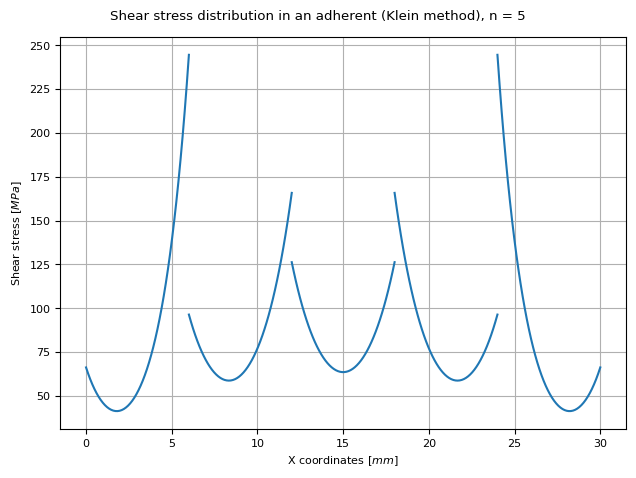

In [92]:
fig, axs = plt.subplots(1)

n = 5
fstep = F / n
tstep = 2e-3 / (n+1)
lustep = 30e-3 / n
t1list = np.linspace(tstep, 2e-3, n, endpoint=False)
t2list = 2e-3 - t1list

for idx in range(n):
    Mat1 = Material(t1=t1list[idx], t2=t2list[idx], b=20e-3, E1=70e9, E2=70e9, G_kl=2e9, d=0.3e-3, lu=lustep)

    xs, taux_klein = klein_model(N, Mat1, fstep)

    axs.plot((xs + lustep*idx) * 1e3 , taux_klein / 1e6, color='tab:blue')

fig.suptitle(f"Shear stress distribution in an adherent (Klein method), n = {n}")
matplotlib.rc('font', **{'size': 8})
axs.set_xlabel(r"X coordinates $[mm]$")
axs.set_ylabel(r"Shear stress $[MPa]$")
axs.grid()

fig.tight_layout()
plt.show()

### Question 4.2 (2 points)

#### What happens when $n$ approaches infinity? Plot this using your code from question 4.1. Explain why the shape makes sense. Do this by comparing a step joint with $n$ steps and a scarf joint.

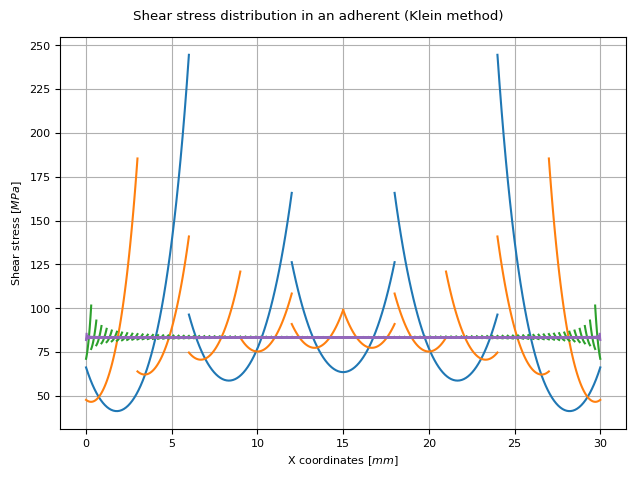

In [93]:
fig, axs = plt.subplots(1)
fig.suptitle(f"Shear stress distribution in an adherent (Klein method)")

nlist = [5, 10, 100, 1000]
colorlist = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']

for i, n in enumerate(nlist):
    fstep = F / n
    tstep = 2e-3 / (n+1)
    lustep = 30e-3 / n
    t1list = np.linspace(tstep, 2e-3, n, endpoint=False)
    t2list = 2e-3 - t1list

    for idx in range(n):
        Mat1 = Material(t1=t1list[idx], t2=t2list[idx], b=20e-3, E1=70e9, E2=70e9, G_kl=2e9, d=0.3e-3, lu=lustep)

        xs, taux_klein = klein_model(N, Mat1, fstep)

        axs.plot((xs + lustep*idx) * 1e3 , taux_klein / 1e6, color=colorlist[i])




matplotlib.rc('font', **{'size': 8})
axs.set_xlabel(r"X coordinates $[mm]$")
axs.set_ylabel(r"Shear stress $[MPa]$")
axs.grid()

fig.tight_layout()
plt.show()

As n approaches a very large number the distribution moves towards a constant shear stress throughout the joint. This makes sense because with increasing n the step joint geometrically approaches a scarf joint.

### Question 5.1 (3 points)

#### Consider the scarf joint from the image below. Write a function that takes angle $\alpha$ as input and returns the shear- and tensile stresses. Then, use your function to plot the shear- and tensile stresses vs $\alpha$ for $0^{\circ} <\alpha<90 ^{\circ} $

#### The thickness $t$ of the part is 20 mm, the width $b$ is 30 mm. The part is subjected to a tensile force of 10 kN.

![title](scarfjoint.png)

### Question 5.2 (3 points)

#### At which value for $\alpha$ does the tensile stress peak? At which value for $\alpha$ does the shear stress peak? Explain why this makes sense. Plot a graph, which contains bond-area vs. $\alpha$, to support your explanation.

Answer:

